In [1]:
%load_ext autoreload
%autoreload 2

In [2]:


import image_loader
import torch
csv_file = '../data/movie_data2.csv'
img_dir = '../data/MoviePosters'
pod = image_loader.PosterDataset(csv_file, img_dir, genres = None)

In [3]:
from torch.utils.data import DataLoader

trainSize = int(len(pod) * 0.9)
testSize = len(pod) - trainSize

trainData, testData = torch.utils.data.random_split(pod, [trainSize, testSize])
def batch_function(raw_output):
    xs, ys = zip(*raw_output)
    batchxs = torch.nn.utils.rnn.pad_sequence(xs, batch_first=True)
    batchys = torch.Tensor(ys)
    return batchxs, batchys

BATCH_SIZE = 5
trainDataLoader = DataLoader(trainData, batch_size = BATCH_SIZE, shuffle=True, collate_fn=batch_function)
testDataLoader = DataLoader(testData, batch_size = 1, shuffle=True)

torch.save(trainData, "../datasets/autoTrainData.dataset")
torch.save(testData, "../datasets/autoTestData.dataset")



In [4]:
xs, ys = next(iter(trainDataLoader))
xs.shape

torch.Size([5, 3, 256, 256])

In [5]:
len(trainData)

31995

In [6]:
# download VGG19 model
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = models.vgg19_bn(pretrained=True, progress=True).features.to(device)

c:\Users\ianpe\.conda\envs\main\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ianpe\.conda\envs\main\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# check model architecture
print(vgg_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [8]:
# Initialize the model
vgg_model = vgg_model.to(device)

In [45]:
class PosterEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.ParameterList([ # 3 * 256 * 256
            nn.Conv2d(3, 3, 3, 1, 1),
            nn.Conv2d(3, 3, 3, 1, 1),
            nn.Conv2d(3, 8, 6, 2), # 8 * 126 * 126
            nn.Conv2d(8, 8, 5, 1, 2),
            nn.Conv2d(8, 8, 5, 1, 2),
            nn.Conv2d(8, 32, 6, 2), # 32 * 61 * 61
            nn.Conv2d(32, 32, 7, 1, 3),
            nn.Conv2d(32, 32, 7, 1, 3),
            nn.Conv2d(32, 128, 7, 2), # 128 * 28 * 28
            nn.Conv2d(128, 128, 9, 1, 4),
            nn.Conv2d(128, 128, 9, 1, 4),
            nn.Conv2d(128, 512, 7, 3), # 512 * 8 * 8
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.Conv2d(512, 512, 3, 1, 1),
        ])
        self.lrelu = nn.LeakyReLU()
    def forward(self, input: torch.Tensor):
        """
        input: Batch x 3 x 256 x 256
        output: Batch x (512 * 8 * 8)
        """
        for conv in self.convs:
            input = self.lrelu(conv(input))
        return torch.flatten(input, -3) # batch * (512 * 8 * 8)

class PosterDecoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # inp: 512 * 8 * 8
        self.convs = nn.ParameterList([
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ConvTranspose2d(512, 128, 7, 3), # 128 * 28 * 28
            nn.Conv2d(128, 128, 9, 1, 4),
            nn.Conv2d(128, 128, 9, 1, 4),
            nn.ConvTranspose2d(128, 32, 7, 2), # 32 * 61 * 61
            nn.Conv2d(32, 32, 7, 1, 3),
            nn.Conv2d(32, 32, 7, 1, 3),
            nn.ConvTranspose2d(32, 8, 6, 2), # 8 * 126 * 126
            nn.Conv2d(8, 8, 5, 1, 2),
            nn.Conv2d(8, 8, 5, 1, 2),
            nn.ConvTranspose2d(8, 3, 6, 2), # 3 * 256 * 256
            nn.Conv2d(3, 3, 3, 1, 1),
            nn.Conv2d(3, 3, 3, 1, 1),
        ])
        self.relu = nn.ReLU()
    def forward(self, input: torch.Tensor):
        """
        input: Batch x (512 * 8 * 8)
        output: Batch x 3 x 256 x 256
        """
        input = torch.unflatten(input, -1, (512, 8, 8))
        for layer in self.convs[:-1]:
            input = layer(input)
        output = (self.convs[-1](input))
        return output
    
class PosterAutoEncoder(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, input: torch.Tensor):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

class FlatVGG(nn.Module):
    def __init__(self, vgg_model) -> None:
        super().__init__()
        self.vgg_model = vgg_model
    def forward(self, input):
        return torch.flatten(self.vgg_model(input), -3)



In [46]:
vgg_model = models.vgg19_bn(pretrained=False).features.to(device)
encoder = FlatVGG(vgg_model)
decoder = PosterDecoder().to(device)
autoencoder = PosterAutoEncoder(encoder, decoder).to(device)

autoencoder_optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
autoencoder_loss = nn.MSELoss(reduction="mean")

In [60]:
# encoder = encoder.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


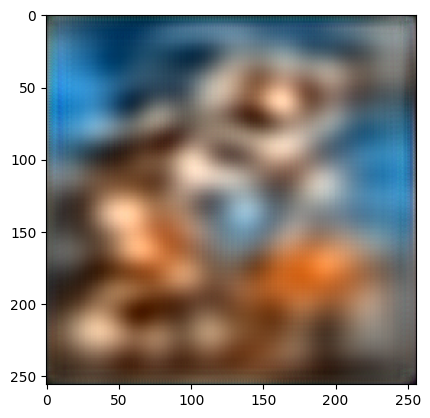

In [73]:
import matplotlib.pyplot as plt
import numpy as np
with torch.no_grad():
    idx = 0
    img = autoencoder(pod[idx][0][None, :, :, :].to(device))[0].cpu()
    # enc = autoencoder.encoder(pod[idx][0][None, :, :, :].to(device)[0].cpu())
    plt.imshow(img.permute((1, 2, 0)).to(torch.int32))
    # plt.imshow(pod[idx][0].permute((1, 2, 0)).to(torch.int32))
    # print(img)
    # # print(pod[1][0][None, :, :, :] - img)

In [16]:
# Train the model
from tqdm import tqdm
import numpy as np

def train_autoencoder(in_model: PosterAutoEncoder, criterion, optimizer: torch.optim.Optimizer, num_epochs: int):
    # uses global training data
    print(f"Training for {num_epochs} epoch(s).")
    for epoch in range(num_epochs):
        in_model.train()
        running_loss = 0.0
        pbar = tqdm(trainDataLoader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            optimizer.zero_grad()
            outputs = in_model(images)
            loss = criterion(images, outputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_description(f"Last Train Loss: {loss.item():.6f}")
        print(f'Epoch {epoch+1}, Average Train Loss: {running_loss/len(trainDataLoader):.6f}')

        print("Validating Model")
        in_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(testDataLoader):
                images = images.to(device)
                outputs = in_model(images)
                loss = criterion(images, outputs)
                val_loss += loss.item()
        print(f'Validation Loss: {val_loss/len(testDataLoader)}')

In [48]:
train_autoencoder(autoencoder, autoencoder_loss, autoencoder_optim, 1)

Training for 1 epoch(s).


Last Train Loss: 4443.988770: 100%|██████████| 6399/6399 [18:50<00:00,  5.66it/s]  


Epoch 1, Average Train Loss: 24574.050389
Validating Model


100%|██████████| 3555/3555 [00:54<00:00, 64.86it/s]

Validation Loss: 4332.079375963171


In [50]:
autoencoder_optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
train_autoencoder(autoencoder, autoencoder_loss, autoencoder_optim, 1)

Training for 1 epoch(s).


Last Train Loss: 3148.014648: 100%|██████████| 6399/6399 [18:52<00:00,  5.65it/s]


Epoch 1, Average Train Loss: 3505.146014
Validating Model


100%|██████████| 3555/3555 [00:55<00:00, 64.49it/s]

Validation Loss: 2793.283445527282


In [51]:
train_autoencoder(autoencoder, autoencoder_loss, autoencoder_optim, 1)

Training for 1 epoch(s).


Last Train Loss: 2313.890625: 100%|██████████| 6399/6399 [18:52<00:00,  5.65it/s]


Epoch 1, Average Train Loss: 2609.534338
Validating Model


100%|██████████| 3555/3555 [00:55<00:00, 64.63it/s]

Validation Loss: 2461.291032407522


In [57]:
autoencoder_optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-5)
train_autoencoder(autoencoder, autoencoder_loss, autoencoder_optim, 1)

Training for 1 epoch(s).


Last Train Loss: 2455.362305: 100%|██████████| 6399/6399 [18:53<00:00,  5.64it/s]


Epoch 1, Average Train Loss: 2088.728160
Validating Model


100%|██████████| 3555/3555 [00:55<00:00, 63.67it/s]

Validation Loss: 2032.0569045312293


In [65]:
autoencoder_optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-6)
train_autoencoder(autoencoder, autoencoder_loss, autoencoder_optim, 2)

Training for 2 epoch(s).


Last Train Loss: 2376.280273: 100%|██████████| 6399/6399 [19:13<00:00,  5.55it/s]


Epoch 1, Average Train Loss: 2021.817721
Validating Model


100%|██████████| 3555/3555 [00:58<00:00, 60.38it/s]


Validation Loss: 1995.3972211963853


Last Train Loss: 1665.728516: 100%|██████████| 6399/6399 [19:04<00:00,  5.59it/s]


Epoch 2, Average Train Loss: 2012.735231
Validating Model


100%|██████████| 3555/3555 [00:55<00:00, 64.05it/s]

Validation Loss: 1987.7755249109282


In [66]:
autoencoder_optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-7)
train_autoencoder(autoencoder, autoencoder_loss, autoencoder_optim, 2)
torch.save(autoencoder.state_dict(), "../models/vgg_arch_ae.pt")

Training for 2 epoch(s).


Last Train Loss: 2358.576172: 100%|██████████| 6399/6399 [18:53<00:00,  5.65it/s]


Epoch 1, Average Train Loss: 2006.934450
Validating Model


100%|██████████| 3555/3555 [00:55<00:00, 64.25it/s]


Validation Loss: 2008.9610206872267


Last Train Loss: 2150.432129: 100%|██████████| 6399/6399 [18:52<00:00,  5.65it/s]


Epoch 2, Average Train Loss: 2005.680596
Validating Model


100%|██████████| 3555/3555 [00:54<00:00, 65.15it/s]


Validation Loss: 1977.7305531218753


In [71]:
train_autoencoder(autoencoder, autoencoder_loss, autoencoder_optim, 3)
torch.save(autoencoder.state_dict(), "../models/vgg_arch_ae.pt")

Training for 3 epoch(s).


Last Train Loss: 1823.688599: 100%|██████████| 6399/6399 [18:48<00:00,  5.67it/s]


Epoch 1, Average Train Loss: 2004.534193
Validating Model


100%|██████████| 3555/3555 [00:55<00:00, 64.57it/s]


Validation Loss: 1991.3736104243583


Last Train Loss: 2351.222412: 100%|██████████| 6399/6399 [18:50<00:00,  5.66it/s]


Epoch 2, Average Train Loss: 2004.818021
Validating Model


100%|██████████| 3555/3555 [00:55<00:00, 64.11it/s]


Validation Loss: 1983.355111861732


Last Train Loss: 2369.527832: 100%|██████████| 6399/6399 [18:48<00:00,  5.67it/s]


Epoch 3, Average Train Loss: 2002.666782
Validating Model


100%|██████████| 3555/3555 [00:54<00:00, 65.04it/s]


Validation Loss: 1983.395246700496


In [41]:

torch.save(trainData, "../datasets/traindata.dataset")
torch.save(testData, "../datasets/testdata.dataset")

In [42]:
for x in tqdm(trainDataLoader):
    pass

100%|██████████| 6399/6399 [01:21<00:00, 78.95it/s]


In [75]:
total_params = 0
for param in autoencoder.parameters():
    print(param.size().numel())
    total_params += param.size().numel()
print(f"{total_params:,}")

1728
64
64
64
36864
64
64
64
73728
128
128
128
147456
128
128
128
294912
256
256
256
589824
256
256
256
589824
256
256
256
589824
256
256
256
1179648
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
512
512
2359296
512
2359296
512
3211264
128
1327104
128
1327104
128
200704
32
50176
32
50176
32
9216
8
1600
8
1600
8
864
3
81
3
81
3
30,935,491
